***
***

# 0. Basics of the Sakura Bloom-cycle (5pts total)

In a year, sakura trees basically go through 4 phases: energy production, hibernation, growth, and of course flowering. These phases
roughly follow the seasons, but not exactly. <br>

   Production phase： Initial development of the buds（Summer-Fall） <br>
   Hibernation phase： Bud growth stops while the tree goes into hibernation（Late Fall-Winter） <br>
   Growth phase： Buds once again continue to grow when the tree comes out of its winter hibernation（Late Winter-Spring） <br>
   Flowering phase： The buds finally bloom in spring (as climate conditions allow), once they have been able to fully develop.（Spring） <br>
    
Each year, near the end of winter but before the trees finally bloom, the hibernation period ends. The sakura that rested through the winter once gain become metabolically active, and the buds continue to grow (though we may not immediately notice when this happens.) However, the cycle is not simply clockwork- for example, in places where the temperature is above 20℃ year-round, the trees are unable to hibernate sufficiently, and thus cannot blossom.
    
In this challenge, we have outlined the basic mechanism by which the sakura reach their eventual bloom-date. We consider building a bloom-date prediction model for the case of sakura in Tokyo, with the data split as follows: <br>
    
Test years： 1966, 1971, 1985, 1994, and 2008 <br>
Training years: 1961 to 2017 (Excluding the test years) <br>
    
You should fit the model to the data from the training years, then use the model to predict the bloom-date for each of the test years. The 3 models to be applied to the data are described below.




### Problem 0-1: (5pts)
Acquire data of sakura blooming date (桜の開花日) for Tokyo from 1961 to 2017 using the Japanese Meteorological Agency website (気象庁).

## Data Preprocessing

In [153]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
%matplotlib inline

from pprint import pprint

import seaborn as sns

from collections import defaultdict
from datetime import datetime
from sklearn.metrics import r2_score, mean_squared_error

import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

***

In [106]:
## Default Data path
WEATHER_DATA_PATH = r'Dataset\tokyo_en.csv'
BLOOM_DATA_PATH = r'Dataset\BloomDate.csv'



## Data Export for regression model
WEATHER_DATA_EXPORT =  r'Dataset\preprocessed_weather_data.csv'
BLOOM_DATA_EXPORT = r'Dataset\preprocessed_bloom_data.csv'


## Data Export path for Neural Network
NN_WEATHER_DATA_TRAIN_EXPORT =  r'Dataset\nn_preprocessed_train_weather_data.csv'
NN_WEATHER_DATA_TEST_EXPORT =  r'Dataset\nn_preprocessed_test_weather_data.csv'
NN_WEATHER_DATA_VALIDATION_EXPORT =  r'Dataset\nn_preprocessed_validation_weather_data.csv'


In [107]:
weather_data = pd.read_csv(WEATHER_DATA_PATH)
bloom_data = pd.read_csv(BLOOM_DATA_PATH)

In [108]:
weather_data.head()

,serial,year,month,date,local_avg_pressure,sea_level_avg_pressure,total_rainfall,max_rain_1_day,max_rain_10_min,avg_temp,highest_temp,lowest_temp,avg_hum,lowest_hum,sunshine_time
0,0,1961,1,1,1011.7,1012.4,0.0,0.0,0.0,2.1,7.9,-3.9,41,15,8.6
1,1,1961,1,2,1020.2,1021.0,0.0,0.0,0.0,1.5,9.2,-3.3,51,26,8.7
2,2,1961,1,3,1021.3,1022.1,0.1,0.8,0.0,2.5,7.3,-2.4,58,37,5.4
3,3,1961,1,4,1004.6,1005.3,20.2,13.9,3.2,4.7,11.5,0.6,60,38,1.0
4,4,1961,1,5,1016.3,1017.0,0.0,0.0,0.0,3.8,7.7,1.4,33,19,8.3


In [109]:
weather_data = weather_data.drop(['serial'], axis = 1)

In [110]:
years = weather_data['year'].unique()

In [111]:
years

array([1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017], dtype=int64)

In [112]:
preprocessed_weather_data = pd.DataFrame()

In [113]:
for year in years:
    temp_data = weather_data[weather_data['year'] == year]
    
    temp_data = temp_data[temp_data['month'] <= 4]
    
    temp_data.reset_index(inplace=True, drop=True)
    
    temp_data['day'] = 0
    
    for i in range(len(temp_data)):
        date = datetime(int(temp_data.loc[i, 'year']), int(temp_data.loc[i, 'month']), int(temp_data.loc[i, 'date']))
        temp_data.loc[i, 'day'] = int(date.timetuple().tm_yday)
        
        
        #print(year, temp_data.loc[i, 'day'])
        
    
    preprocessed_weather_data = pd.concat([preprocessed_weather_data, temp_data]) 

In [115]:
preprocessed_weather_data.isnull().sum()

year                      0
month                     0
date                      0
local_avg_pressure        0
sea_level_avg_pressure    0
total_rainfall            0
max_rain_1_day            0
max_rain_10_min           0
avg_temp                  0
highest_temp              0
lowest_temp               0
avg_hum                   0
lowest_hum                0
sunshine_time             0
day                       0
dtype: int64

In [116]:
preprocessed_weather_data.reset_index(inplace=True, drop=True)

In [117]:
columns = preprocessed_weather_data.columns.values

In [118]:
sequence = ['year', 'month', 'date', 'day', 'local_avg_pressure',
       'sea_level_avg_pressure', 'total_rainfall', 'max_rain_1_day',
       'max_rain_10_min', 'avg_temp', 'highest_temp', 'lowest_temp',
       'avg_hum', 'lowest_hum', 'sunshine_time']

In [119]:
preprocessed_weather_data = preprocessed_weather_data.reindex(columns=sequence)

In [120]:
preprocessed_weather_data.to_csv(WEATHER_DATA_EXPORT, sep=',', index=False)

In [121]:
bloom_data.head()

,year,month,date
0,1961,4,1
1,1962,4,1
2,1963,4,1
3,1964,4,2
4,1965,4,2


In [122]:
bloom_data['day'] = 0

In [123]:
for i in range(len(bloom_data)):
    date = datetime(int(bloom_data.loc[i, 'year']), int(bloom_data.loc[i, 'month']), int(bloom_data.loc[i, 'date']))
    bloom_data.loc[i, 'day'] = int(date.timetuple().tm_yday)

In [124]:
plot_bloom_data = bloom_data.copy()
bloom_data.to_csv(BLOOM_DATA_EXPORT, sep=',', index=False)

***

Sakura requires a constant amount of temperature to bloom. For constant it means a threshold amount of heat, rain, pressure, humidity. So taking a cumulative sum of the factor may increase the chance of finding correlation and better predictions. As part of my observation, I treated the problem as a classification one. Rather than putting 52 data in the neural network and making a regression I kept only first four months weather data. Abd created a new column "has_bloomed". From January 1st to the blooming date it remains 0 but from the bloom date to onwards it remains 1. So, from my model I had to find the bit shift. The first bit shift was taken as the bloom date.

In [21]:
def preprocess(weather_data, bloom_day):
    
    weather_data.reset_index(inplace=True, drop=True)
    
    weather_data['highest_temp_cumsum'] = weather_data['highest_temp'].cumsum()
    weather_data['avg_temp_cumsum'] = weather_data['avg_temp'].cumsum()
    weather_data['lowest_temp_cumsum'] = weather_data['lowest_temp'].cumsum()
    weather_data['temp_difference'] = weather_data['highest_temp'] - weather_data['lowest_temp']
    weather_data['temp_difference_cumsum'] = weather_data['temp_difference'].cumsum()    
    weather_data['humidity_difference'] = weather_data['avg_hum'] - weather_data['lowest_hum']
    weather_data['humidity_difference_cumsum'] = weather_data['humidity_difference'].cumsum()
    weather_data['sunshine_cumsum'] = weather_data['sunshine_time'].cumsum()
    
    
    weather_data['has_bloomed'] = 0
    for i in range(len(weather_data)):
        if weather_data.loc[i, 'day'] < bloom_day:
            weather_data.loc[i, 'has_bloomed'] = 0
        else:
            weather_data.loc[i, 'has_bloomed'] = 1
    
    return weather_data

In [22]:
years = preprocessed_weather_data['year'].unique()

In [23]:
preprocessed_data = pd.DataFrame()

In [24]:
for year in years:
    data = preprocessed_weather_data[preprocessed_weather_data['year'] == year]
    bloom = bloom_data[bloom_data['year'] == year]
    
    bloom.reset_index(inplace=True, drop=True)

    bloom_day = bloom.loc[0, 'day']
    temp = preprocess(data, bloom_day)
    
    preprocessed_data = pd.concat([preprocessed_data, temp]) 

In [25]:
 preprocessed_data.head()

,year,month,date,day,local_avg_pressure,sea_level_avg_pressure,total_rainfall,max_rain_1_day,max_rain_10_min,avg_temp,...,sunshine_time,highest_temp_cumsum,avg_temp_cumsum,lowest_temp_cumsum,temp_difference,temp_difference_cumsum,humidity_difference,humidity_difference_cumsum,sunshine_cumsum,has_bloomed
0,1961,1,1,1,1011.7,1012.4,0.0,0.0,0.0,2.1,...,8.6,7.9,2.1,-3.9,11.8,11.8,26,26,8.6,0
1,1961,1,2,2,1020.2,1021.0,0.0,0.0,0.0,1.5,...,8.7,17.1,3.6,-7.2,12.5,24.3,25,51,17.3,0
2,1961,1,3,3,1021.3,1022.1,0.1,0.8,0.0,2.5,...,5.4,24.4,6.1,-9.6,9.7,34.0,21,72,22.7,0
3,1961,1,4,4,1004.6,1005.3,20.2,13.9,3.2,4.7,...,1.0,35.9,10.8,-9.0,10.9,44.9,22,94,23.7,0
4,1961,1,5,5,1016.3,1017.0,0.0,0.0,0.0,3.8,...,8.3,43.6,14.6,-7.6,6.3,51.2,14,108,32.0,0


In [26]:
preprocessed_data.columns

Index(['year', 'month', 'date', 'day', 'local_avg_pressure',
       'sea_level_avg_pressure', 'total_rainfall', 'max_rain_1_day',
       'max_rain_10_min', 'avg_temp', 'highest_temp', 'lowest_temp', 'avg_hum',
       'lowest_hum', 'sunshine_time', 'highest_temp_cumsum', 'avg_temp_cumsum',
       'lowest_temp_cumsum', 'temp_difference', 'temp_difference_cumsum',
       'humidity_difference', 'humidity_difference_cumsum', 'sunshine_cumsum',
       'has_bloomed'],
      dtype='object')

In [27]:
sequence = ['year', 'month', 'date', 'day', 'local_avg_pressure',
        'sea_level_avg_pressure', 'total_rainfall', 'max_rain_1_day',
        'max_rain_10_min', 'avg_temp', 'avg_temp_cumsum',  'highest_temp', 'highest_temp_cumsum',
        'lowest_temp', 'lowest_temp_cumsum', 'temp_difference', 'temp_difference_cumsum',
        'avg_hum', 'lowest_hum', 'humidity_difference', 'humidity_difference_cumsum',
        'sunshine_time', 'sunshine_cumsum', 'has_bloomed'
        ]



In [28]:
preprocessed_data = preprocessed_data.reindex(columns=sequence)

In [29]:
def plot_correlation(corr):
    plt.figure(figsize=(10,7))
    sns.heatmap(corr)
    plt.show()

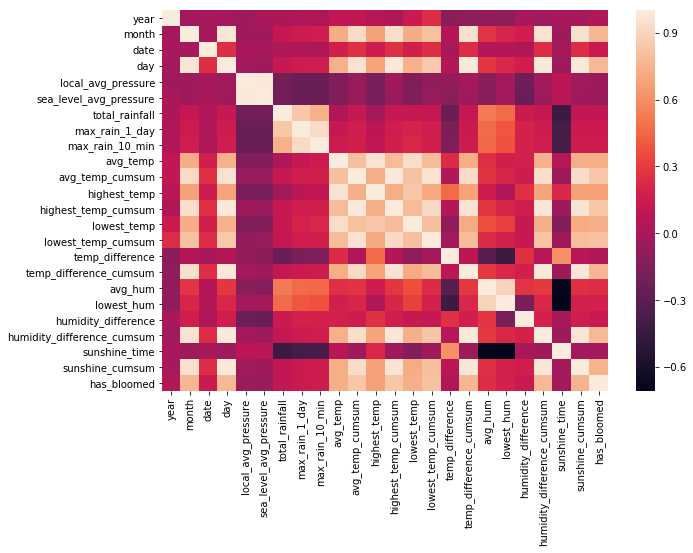

In [30]:
plot_correlation(preprocessed_data.corr())

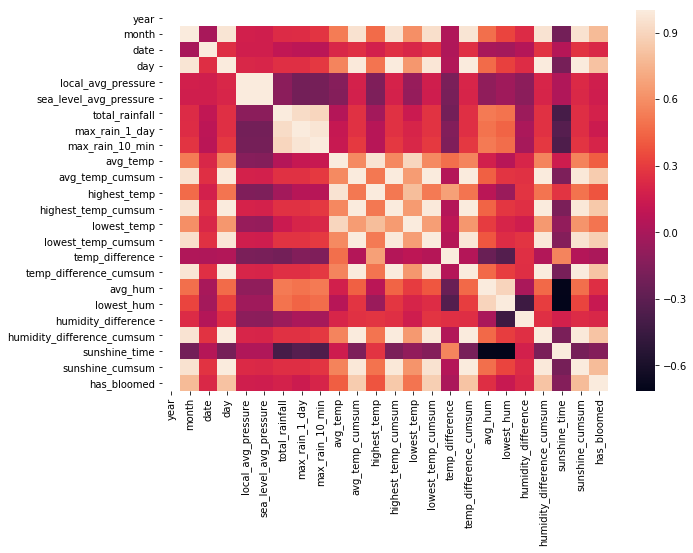

In [31]:
plot_correlation(preprocessed_data[preprocessed_data['year'] == 2010].corr())

In [32]:
preprocessed_data.drop(['local_avg_pressure', 'sea_level_avg_pressure', 
                        'total_rainfall', 'month', 'date',
                        'max_rain_1_day', 'max_rain_10_min'], axis = 1, inplace=True)

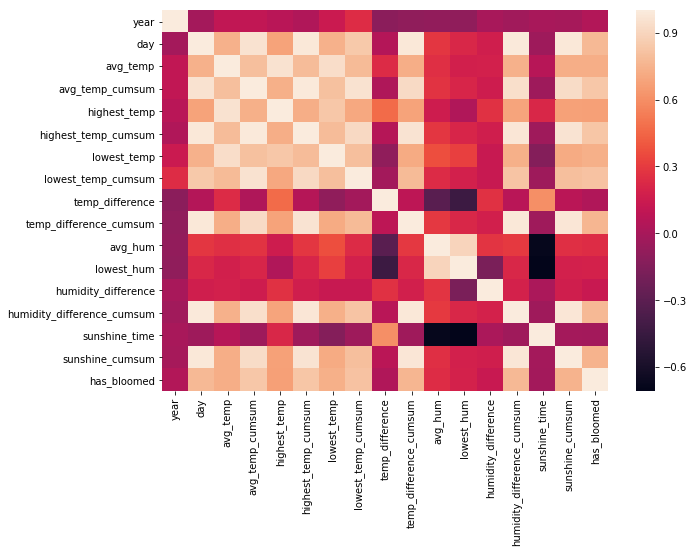

In [33]:
plot_correlation(preprocessed_data.corr())

In [34]:
test_years = [1966, 1971, 1985, 1994, 2008]

In [35]:
test_weather_data = list()

In [36]:
for year in test_years:
    test_weather_data.append(preprocessed_data[preprocessed_data['year'] == year])

test_weather_data = pd.concat(test_weather_data)

In [37]:
test_weather_data.reset_index(inplace=True, drop = True)

In [38]:
test_weather_data['year'].unique()

array([1966, 1971, 1985, 1994, 2008], dtype=int64)

In [39]:
train_weather_data = pd.concat([preprocessed_data, test_weather_data, test_weather_data]).drop_duplicates(keep = False)

In [40]:
train_weather_data['year'].unique()

array([1961, 1962, 1963, 1964, 1965, 1967, 1968, 1969, 1970, 1972, 1973,
       1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984,
       1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1995, 1996, 1997,
       1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2009,
       2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017], dtype=int64)

In [41]:
validation_years = [1968, 1975, 1983, 1990, 1999, 2005, 2011]

In [42]:
validation_weather_data = list()

In [43]:
for year in validation_years:
    validation_weather_data.append(preprocessed_data[preprocessed_data['year'] == year])

validation_weather_data = pd.concat(validation_weather_data)

In [44]:
validation_weather_data.reset_index(inplace=True, drop=True)

In [45]:
train_weather_data = pd.concat([train_weather_data, validation_weather_data, validation_weather_data]).drop_duplicates(keep = False)

In [46]:
validation_weather_data['year'].unique()

array([1968, 1975, 1983, 1990, 1999, 2005, 2011], dtype=int64)

In [47]:
train_weather_data['year'].unique()

array([1961, 1962, 1963, 1964, 1965, 1967, 1969, 1970, 1972, 1973, 1974,
       1976, 1977, 1978, 1979, 1980, 1981, 1982, 1984, 1986, 1987, 1988,
       1989, 1991, 1992, 1993, 1995, 1996, 1997, 1998, 2000, 2001, 2002,
       2003, 2004, 2006, 2007, 2009, 2010, 2012, 2013, 2014, 2015, 2016,
       2017], dtype=int64)

In [48]:
train_weather_data.to_csv(NN_WEATHER_DATA_TRAIN_EXPORT, sep = ',', index = False)
test_weather_data.to_csv(NN_WEATHER_DATA_TEST_EXPORT, sep = ',', index= False)
validation_weather_data.to_csv(NN_WEATHER_DATA_VALIDATION_EXPORT, sep=',', index=False)

In [49]:
validation_weather_data.shape

(841, 17)

***
## 1. Prediction using the "600 Degree Rule" (15pts total)

For a rough approximaton of the bloom-date, we start with a simple "rule-based" prediction model, called the "600 Degree Rule". The rule consists of logging the maximum temperature of each day, starting  on February 1st, and sum these temperatures until the sum surpasses 600$^\circ$C. The day that this happens is the predicted bloom-date. This 600$^\circ$C threshold is used to easily predict bloom-date in various locations varies by location. However, for more precise predictions, it should be set differently for every location. In this challenge, we verify the accuracy of the "600 Degree Rule" in the case of Tokyo.

In [154]:
weather_data = pd.read_csv(WEATHER_DATA_EXPORT)
bloom_data = pd.read_csv(BLOOM_DATA_EXPORT)

In [155]:
test_years = [1966, 1971, 1985, 1994, 2008]

In [156]:
test_weather_data = list()
test_bloom_data = list()

In [157]:
for year in test_years:
    test_weather_data.append(weather_data[weather_data['year'] == year])
    test_bloom_data.append(bloom_data[bloom_data['year'] == year])

In [158]:
test_weather_data = pd.concat(test_weather_data)
test_bloom_data = pd.concat(test_bloom_data)

In [159]:
test_weather_data.reset_index(inplace=True, drop = True)

In [160]:
test_weather_data.year.unique()

array([1966, 1971, 1985, 1994, 2008], dtype=int64)

In [161]:
test_years = test_bloom_data.year.unique()

In [162]:
train_weather_data = pd.concat([weather_data, test_weather_data, test_weather_data]).drop_duplicates(keep = False)
train_bloom_data = pd.concat([bloom_data, test_bloom_data, test_bloom_data]).drop_duplicates(keep = False)

In [163]:
train_years = train_weather_data['year'].unique()

print(train_years)

[1961 1962 1963 1964 1965 1967 1968 1969 1970 1972 1973 1974 1975 1976
 1977 1978 1979 1980 1981 1982 1983 1984 1986 1987 1988 1989 1990 1991
 1992 1993 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006
 2007 2009 2010 2011 2012 2013 2014 2015 2016 2017]


In [178]:
class Sakura:
    
    def __init__(self):
        self.__cumulated_temperature = list()
        self.__training_year = list()
        self.__prediction = defaultdict(list)
    
    def accumulated_temperature(self, weather_data, bloom_data):
        weather_data = weather_data[weather_data['month'] >= 2]
        
        weather_data.reset_index(inplace=True, drop = True)
        bloom_data.reset_index(inplace=True , drop = True)
        
        t_sum = 0
        
        for i in range(0, len(weather_data)):
            t_sum += weather_data.loc[i, 'highest_temp']
            if weather_data.loc[i, 'date'] == bloom_data.loc[0, 'date']:
                if weather_data.loc[i , 'month'] == bloom_data.loc[0, 'month']:
                    break
            #else: 
                #t_sum += weather_data.loc[i, 'highest_temp']
        self.__training_year.append(bloom_data.loc[0, 'year'])
        #print('year',bloom_data.loc[0, 'year'] ,'temp:',t_sum)
        self.__cumulated_temperature.append(t_sum)
        self.__accumulated_temperature_mean = np.mean(self.__cumulated_temperature)
    
    def get_accumulated_temperature_mean(self):
        return self.__accumulated_temperature_mean
        
    def plot_accumulated_temperature(self):
        if not self.__cumulated_temperature or not self.__training_year:
            raise ValueError('Accumulated temperature must be calculated before plotting.')
        plt.figure(figsize=(15,5))
        plt.scatter(self.__training_year, self.__cumulated_temperature, label = 'Temp for year')
        plt.axhline(600, color='r', label='600 Degree')
        plt.xlabel('Year', fontsize=13)
        plt.ylabel('Sum of Temperature till blooming date', fontsize=13)
        plt.grid()
        plt.legend()
        plt.show()
        
        
    def predict_test_data(self, weather_data, bloom_data, threshold):
        weather_data = weather_data[weather_data['month'] >= 2]
        
        weather_data.reset_index(inplace=True, drop = True)
        bloom_data.reset_index(inplace=True , drop = True)
        
        index = 0
        t_sum = 0
        
        for i in range(0 , len(weather_data)):
            t_sum += weather_data.loc[i, 'highest_temp']
            if t_sum >= threshold:
                index = i
                break
        self.__prediction[threshold].append((weather_data.loc[index, 'year'], weather_data.loc[index, 'month'], 
                                             weather_data.loc[index, 'date']))
    
    def get_prediction(self):
        return self.__prediction
    
    def error(self, predictions, actuals, thershold):
        
        predicted_day = list()
        actual_day = list()
        
        actuals.reset_index(inplace=True , drop = True)
        
        for pred in predictions:
            date = datetime(int(pred[0]), int(pred[1]), int(pred[2]))
            predicted_day.append(date.timetuple().tm_yday)
        
        for i in range(len(actuals)):
            date = datetime(actuals.loc[i, 'year'], actuals.loc[i, 'month'], actuals.loc[i, 'date'] )
            actual_day.append(date.timetuple().tm_yday)
        
        rmse = mean_squared_error(predicted_day, actual_day)
        r2_error = r2_score(actual_day, predicted_day)            
        
        return rmse, r2_error

In [179]:
sakura = Sakura()

for year in train_years:
    weather_data = train_weather_data[train_weather_data['year'] == year]
    bloom_data = train_bloom_data[train_bloom_data['year'] == year]
    sakura.accumulated_temperature(weather_data, bloom_data)


### Problem 1-1: (5pts)
From here-on, we refer to the bloom-date in a given year $j$ as $BD_{j}$. For each year in the training data, calculate the accumulated daily maximum temperature from February 1st to the actual bloom-date $BD_{j}$, and plot this accumulated value over the training period. Then, average this accumulated value as $T_{mean}$, and verify whether we should use 600$^\circ$C as a rule for Tokyo.

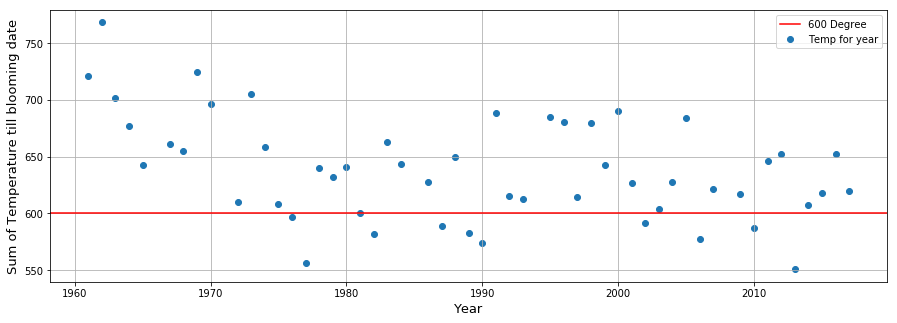

638.3557692307693

In [180]:
sakura.plot_accumulated_temperature()
sakura.get_accumulated_temperature_mean()

### Problem 1-2: (10pts)

Use the average accumulated value $T_{mean}$ calculated in 1-1 to predict $BD_{j}$ for each test year, and show the error from the actual $BD_{j}$. Compare to the prediction results when 600$^\circ$C is used a threshold value, and evaluate both models using the coefficient of determination ($R^2$ score).

In [181]:
threshold_values = [600.00]
threshold_values.append(sakura.get_accumulated_temperature_mean())

for threshold in threshold_values:
    for year in test_years:
        weather_data = test_weather_data[test_weather_data['year'] == year]
        bloom_data = test_bloom_data[test_bloom_data['year'] == year]
        sakura.predict_test_data(weather_data, bloom_data , threshold)

In [182]:
predictions = sakura.get_prediction()
pprint(predictions)

defaultdict(<class 'list'>,
            {600.0: [(1966, 3, 20),
                     (1971, 3, 27),
                     (1985, 3, 29),
                     (1994, 3, 28),
                     (2008, 3, 23)],
             638.3557692307693: [(1966, 3, 23),
                                 (1971, 3, 29),
                                 (1985, 4, 1),
                                 (1994, 3, 31),
                                 (2008, 3, 25)]})


In [183]:
for key in predictions.keys():
    rmse , r2_error = sakura.error(predictions[key] , test_bloom_data, key)
    print('RMSE for', key, 'threshold value is:', rmse)
    print('R2 Score for', key, 'threshold value is:', r2_error)
    

RMSE for 600.0 threshold value is: 8.8
R2 Score for 600.0 threshold value is: 0.6793002915451896
RMSE for 638.3557692307693 threshold value is: 4.6
R2 Score for 638.3557692307693 threshold value is: 0.8323615160349854


***
## 2. Linear Regression Model: Transform to Standard Temperature (30pts total)

The year to year fluctuation of the bloom-date depends heavily upon the actual temperature fluctuation (not just the accumulated maximum). In order to get to a more physiologically realistic metric,  Sugihara et al. (1986) considered the actual effect of temperature on biochemical activity. They introduced a method of "standardizing" the temperatures measured, according to the fluctuation relative to a standard temperature.

In order to make such a standardization, we apply two major assumptions, outlined below.

#### 1) The Arrhenius equation: <br>

The first assumption, also known in thermodynamics as the "Arrhenius equation", deals with chemical reaction rates and can be written as follows:

$$
k = A \exp{ \Bigl(- \frac{E_{a}}{RT}} \Bigr)
$$ <br>

Basically, it says that each reaction has an activation energy, $E_{a}$ and a pre-exponential factor $A$. Knowing these values for the particular equation, we can find the rate constant $k$ if we know the temperature, $T$, and applying the universal gas constant, $R = 8.314 \rm [J/K・mol]$.

#### 2) Constant output at constant temperature: <br>

The second assumption, is simply that the output of a reaction is a simple product of the duration and the rate constant $k$, and that product is constant even at different temperatures.
    
$$
tk = t'k' = t''k'' = \cdots = \rm{const}
$$ <br>


Making the assumptions above, we can determine a "standard reaction time", $t_{s}$ required for the bloom-date to occur. We can do so in the following way:

<br>
$$
t_{s} = \exp \Bigl( \frac{E_{a}(T_{i, j} - T_{s})}{RT_{i, j}T_{s}}\Bigr)
$$ <br>

We define $T_{i, j}$ as the daily average temperature, and use a standard temperature of $T_{s} = 17^\circ\rm{C}$. For a given year $j$, with the last day of the hibernation phase set as $D_ {j}$, we define the number of "transformed temperature days",  $DTS_{ J}$,  needed to reach from $D_ {j}$ to the bloom-date $BD_{j}$ with the following equation:


<br>
$$
DTS_{j} = \sum_{i=D_{j}}^{BD_{j}} t_{s} = \sum_{i=D_{j}}^{BD_{j}} \exp \Bigl( \frac{E_{a}(T_{i, j} - T_{s})}{RT_{i, j}T_{s}}\Bigr)
$$ <br>



From that equation, we can find the average $DTS$ for $x$ number of years ($DTS_{ mean}$) as follows: 

<br>
$$
\begin{align}
DTS_{\rm{mean}} &= \frac{1}{x} \sum_{j}^{x} DTS_{j} \\
&= \frac{1}{x} \sum_{j}^{x} \sum_{i=D_{j}}^{BD_{j}} \exp \Bigl( \frac{E_{a}(T_{i, j} - T_{s})}{RT_{i, j}T_{s}}\Bigr)
\end{align}
$$ <br> <br>

In this exercise, we assume that $DTS_{ mean}$ and $E_{ a}$ are constant values, and we use the data from the training years to fit these 2 constants. The exercise consists of 4 steps:
1. Calculate the last day of the hibernation phase $D_ {j}$ for every year $j$.
2. For every year $j$, calculate $DTS_{ j}$ as a function of $E_{ a}$, then calculate the average (over training years) $DTS_{ mean}$ also as a function of $E_{ a}$.
3. For every year $j$, and for every value of $E_{ a}$, accumulate $t_{s}$ from $D_ {j}$ and predict the bloom date $BD_{j}^{\rm{pred}}$ as the day the accumulated value surpasses $DTS_{ mean}$. Calculate the bloom date prediction error as a function of $E_{ a}$, and find the optimal $E_{ a}$ value that minimizes that error.
4. Use the previously calculated values of $D_ {j}$, $DTS_{ mean}$, and $E_{ a}$ to predict bloom-day on years from the test set.


### Regression Model

In [184]:
class Sakura_regression:
    
    
    def __init__(self):
        self.__years = list()
        self.__dj_values = list()
        self.__ts_for_discrete_Ea = list()
        self.__yearly_ts_for_all_Ea = list()
        self.__ts_mean = list()
        self.__Ea_values = list()
        self.__test_years = list()
        self.__test_dj_values = list()
        self.__min_Ea = 0
        self.__min_ts = 0
        self.__predictions = list()
       
        
        
    def calculate_dj(self, train_weather_data, train_bloom_data, Lattitude, L, train = True):
        
        train_years = train_weather_data['year'].unique()
        
        for year in train_years:
            weather_data = train_weather_data[train_weather_data['year'] == year]
            bloom_data = train_bloom_data[train_bloom_data['year'] == year]
            bloom_data.reset_index(inplace=True , drop = True)
            
            weather_data = weather_data[weather_data['month'] <= 3]

            Tf = np.average(weather_data['avg_temp']) 
            Dj = 136.75 - 7.689 * Lattitude + 0.133 * np.square(Lattitude) - 1.307 * np.log(L) + 0.144 * Tf + 0.285 * np.square(Tf)
            if train:
                self.__years.append(bloom_data.loc[0, 'year'])
                self.__dj_values.append(np.round(Dj))
            
            else:
                self.__test_years.append(bloom_data.loc[0, 'year'])
                self.__test_dj_values.append(np.round(Dj))
            
            
        if train:
            plt.figure(figsize=(15,5))
            plt.plot(self.__years, self.__dj_values)
            plt.xlabel('Year', fontsize=13)
            plt.ylabel('Dj Values', fontsize=13)
            plt.grid()
            plt.title('Dj Values Vs Year' , fontsize= 16)
            plt.show()
        
    
    def calculate_dtsj(self, train_weather_data, train_bloom_data, kelvin_temp, R, Ts):
        plt.figure(figsize=(15,5)) 
        if not self.__years or not self.__dj_values:
            raise ValueError('Dj should be calculated first')
        
        self.__Ea_values = [x for x in range(5, 41, 1)]
        
        for year, dj in zip(self.__years, self.__dj_values):
        
            weather_data = train_weather_data[train_weather_data['year'] == year]
            bloom_data = train_bloom_data[train_bloom_data['year'] == year]
            
            bloom_data.reset_index(inplace=True , drop = True)
            
            actual_blooming_date = bloom_data.loc[0, 'day']
            
            delta = actual_blooming_date - dj
            
            start_day = dj
            end_day = start_day + delta
            
            sakura_data = weather_data[weather_data['day'] >= start_day]
            sakura_data = sakura_data[sakura_data['day'] <= end_day]
            
            #sakura_data.reset_index(inplace=True, drop = True)
            
            ts_for_year = list()
            
            for Ea in self.__Ea_values:
                ts = 0
                for index, row in sakura_data.iterrows():
                    Tij = row['avg_temp'] + kelvin_temp
                    ts += np.exp(Ea*(Tij-Ts)/(R*Tij*Ts))
                #print('Year:', year, 'Ea:', Ea, 'ts:', ts)
                ts_for_year.append(ts)
            self.__yearly_ts_for_all_Ea.append(ts_for_year)
            
            plt.plot(self.__Ea_values, ts_for_year)
        plt.xlabel("Ea Values", fontsize= 13)
        plt.ylabel("Ts Mean", fontsize= 13)
        plt.title("plotting Ea for all training years", fontsize= 16)
        
        
        
        ## Calculating The Mean
        
        for i in range(len(self.__Ea_values)): 
            ts_to_mean = list()
            
            for ts_values in self.__yearly_ts_for_all_Ea:
                ts_to_mean.append(ts_values[i])
            
            self.__ts_mean.append(np.mean(ts_to_mean))
        
        plt.plot(self.__Ea_values, self.__ts_mean, linewidth = 4.0 , label="Ts Mean" , color = "black")
        plt.legend()
        plt.title("plotting Ts Mean", fontsize= 16)
        plt.grid()
        plt.show()
        
        
        
    def find_optimal_Ea(self, train_weather_data, train_bloom_data, kelvin_temp, R, Ts):
        
        
        error_for_ts = list()
        actuals = train_bloom_data['day'].values
        
        
        for i in range(len(self.__ts_mean)):
            
            predictions = list()
            
            
            Ea = i + 5
            t_min = self.__ts_mean[i]
            ts = 0
            
            for year, dj in zip(self.__years, self.__dj_values):

                weather_data = train_weather_data[train_weather_data['year'] == year]
                bloom_data = train_bloom_data[train_bloom_data['year'] == year]

                bloom_data.reset_index(inplace=True , drop = True)

                actual_blooming_date = bloom_data.loc[0, 'day']

                delta = 100

                start_day = dj

                sakura_data = weather_data[weather_data['day'] >= start_day]

                index = 0
                for i, row in sakura_data.iterrows():
                    Tij = row['avg_temp'] + kelvin_temp
                    ts = ts + np.exp(Ea*(Tij-Ts)/(R*Tij*Ts))
                    if ts >= t_min:
                        ts = 0
                        index = i
                        break
                predictions.append(row['day'])
               
            error = mean_squared_error(predictions, actuals)
            error_for_ts.append(error)
        
        min_Ea_index = min(error_for_ts)
        self.__min_Ea = error_for_ts.index(min_Ea_index) + 5
        self.__min_ts = self.__ts_mean[self.__min_Ea - 5]
        
        plt.figure(figsize=(15,5))
        plt.plot(self.__Ea_values, error_for_ts , label='Ea vs Error')
        plt.plot(self.__min_Ea, min_Ea_index, 'r*', label='optimal Ea')
        plt.title("plotting Ea vs error" , fontsize= 16)
        plt.xlabel("Ea Values" , fontsize= 13)
        plt.ylabel("Error for Ea" , fontsize= 13)
        plt.legend()
        plt.show()
    
    
    
    
    def sakura_predict(self, test_weather_data, test_bloom_data, kelvin_temp, R, Ts, Lattitude, L):
        
        self.calculate_dj(test_weather_data, test_bloom_data, Lattitude, L, train = False)
        
        actuals = test_bloom_data['day'].values
        predictions = list()
        t_min = self.__min_ts
        Ea = self.__min_Ea
        ts = 0
        
        for year, dj in zip(self.__test_years, self.__test_dj_values):
            
            weather_data = test_weather_data[test_weather_data['year'] == year]
            bloom_data = test_bloom_data[test_bloom_data['year'] == year]
            bloom_data.reset_index(inplace=True , drop = True)
            start_day = dj
            sakura_data = weather_data[weather_data['day'] >= start_day]
        
            index = 0
            for i, row in sakura_data.iterrows():
                Tij = row['avg_temp'] + kelvin_temp
                ts = ts + np.exp(Ea*(Tij-Ts)/(R*Tij*Ts))
                if ts >= t_min:
                    ts = 0
                    index = i
                    break
            predictions.append(row['day'])
        
        self.__predictions = predictions
        
        print('R2 score', r2_score(actuals, predictions))
        
    def get_predictions(self):
        return self.__predictions
    
    def get_dj(self):
        return (self.__years, self.__dj_values)

### Problem 2-1: (5pts)
According to Hayashi et al. (2012), the day on which the sakura will awaken from their hibernation phase, $D_{j}$, for a given location, can be approximated by the following equation:
<br> <br>
$$
D_{j} = 136.75 - 7.689 \phi + 0.133 \phi^{2} -1.307\ln L + 0.144T_{F} + 0.285T_{F}^2
$$ <br>

where $\phi$ is the latitude [°N], $L$ is the distance from the nearest coastline [km], and $T_{F}$ is that location's average temperature [°C] over the first 3 months of a given year. In the case of Tokyo, $\phi = 35°40'$ and $L=4\rm{km}$.

Find the $D_{j}$ value for every year $j$ from 1961 to 2017 (including the test years), and plot this value on a graph. 

(In Problem 1, we had assumed a $D_j$ of February 1st.)

In [185]:
## Given Values
Lattitude = 35 + (40/60)
L = 4
Kelvin_temp = 273.15
Ts = 17 + Kelvin_temp
R = (8.314 * 10 ** -3)/4.184


In [186]:
sakura_regression = Sakura_regression()

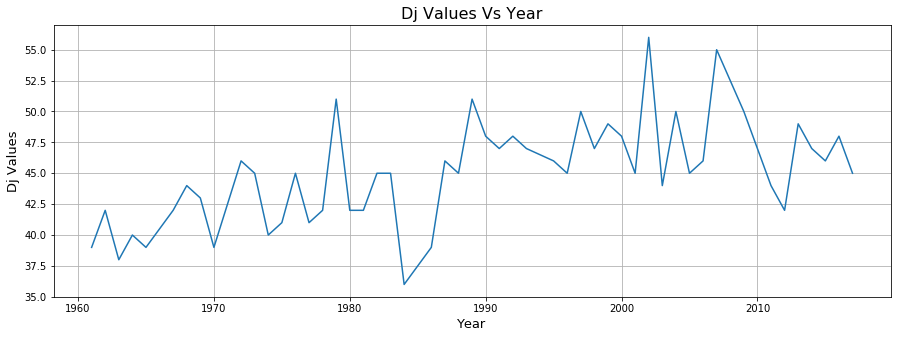

In [187]:
sakura_regression.calculate_dj(train_weather_data, train_bloom_data, Lattitude, L)

### Problem 2-2: (10pts)
Calcluate $DTS_j$ for each year $j$ in the training set for discrete values of $E_{a}$, varying from 5 to 40kcal ($E_{a} = 5, 6, 7, \cdots, 40 \,\rm{kcal}$), and plot this $DTS_j$ against $E_{a}$. Also calculate the average of $DTS_{j}$ over the training period, and indicate it on the plot as $DTS_{mean}$. Pay attention to the units of **every parameter** ($T_{i,j}$, $E_{a}$, ...) in the equation for $t_{s}$. 


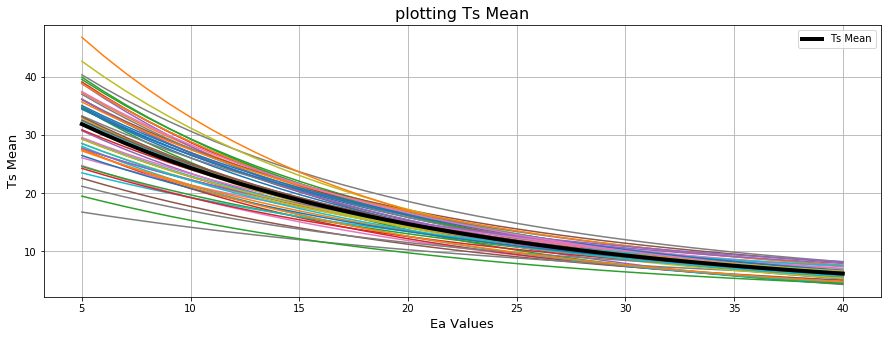

In [188]:
sakura_regression.calculate_dtsj(train_weather_data, train_bloom_data, kelvin_temp=Kelvin_temp, R=R, Ts=Ts)

### Problem 2-3: (11pts)
Using the same $E_{a}$ values and calculated $DTS_{mean}$ from 2-2, predict the bloom date $BD_{j}$ for each of the training years. Find the mean squared error relative to the actual $BD$ and plot it against $E_{a}$. Find the optimal $E_{a}^{*}$ that minimizes that error on the training data.

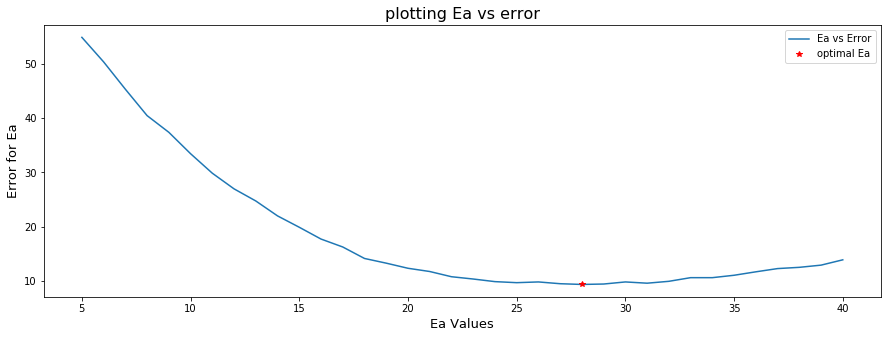

In [189]:
sakura_regression.find_optimal_Ea(train_weather_data, train_bloom_data, kelvin_temp=Kelvin_temp, R=R, Ts=Ts)

### Problem 2-4: (4pts)

Using the $D_j$ dates from problem 2-1, the average $DTS_{mean}$ from 2-2, and the best-fit $E_{a}^{*}$ from 2-3, predict the bloom-dates $BD_j$ for the years in the test set. Determine the error between your predicted $BD_j$ values and the actual values, and evaluate this model using the coefficient of determination ($R^2$ score).

In [190]:
sakura_regression.sakura_predict(test_weather_data, test_bloom_data, Kelvin_temp, R, Ts, Lattitude, L)

R2 score 0.9489795918367347


### Problem 2-5: (extra 10pts)
Discuss any improvements you could make to the model outlined above. If you have a suggestion in particular, describe it. How much do you think the accuracy would be improved?

1)**Standard deviation** of the temperature may help more than the avg temperature.<br>
2)**Buds start to open** date can be a good feature while predicting bloom date.<br>
3)**Soil moisture** can also affect the bloom date.<br>
4)**Global warming** should also take under consideration


***
## 3. Predicting Bloom-date via Neural Network (30pts total)

In [73]:
X_train = pd.read_csv(NN_WEATHER_DATA_TRAIN_EXPORT, sep=',')
X_test = pd.read_csv(NN_WEATHER_DATA_TEST_EXPORT, sep=',')
Valid_train = pd.read_csv(NN_WEATHER_DATA_VALIDATION_EXPORT, sep=',')

In [74]:
Y_train = X_train['has_bloomed']
Y_test = X_test['has_bloomed']
Valid_test = Valid_train['has_bloomed']

In [75]:
X_train.drop('has_bloomed', axis = 1, inplace = True)
X_test.drop('has_bloomed', axis = 1, inplace = True)
Valid_train.drop('has_bloomed', axis = 1, inplace = True)

In [76]:
class Sequential_Model:
    
    
    def __init__(self, seed = 1234):
        self.__current_layer = -1
        self.__weights = list()
        self.__biases = list()
        self.__dropout = list()
        self.__l2_regularizer = list()
        self.__activation = list()
        self.__training_cost = list()
        self.__validation_cost = list()
        self.__regularize = 0
        
        tf.random.set_random_seed(seed)
        
        self.__session = tf.Session()
        
        
    def __del__(self):
        self.__session.close()
    
    
    
    def Add_Dense_layer(self, input_shape, output_shape, activation_function = 'leaky_relu', dropout_rate = 0.0):
        """
        params: 
        input shape - dense layer's input shape
        output shape - dense layer's output shape
        activation_function - activation function for the layer (Default: leaky_relu)
        dropout_rate - dropout rate of the layer (default 0.0 means no dropout)
        
        """
        self.__current_layer = self.__current_layer + 1
        
        self.__weights.append(tf.Variable(tf.random.truncated_normal([input_shape, output_shape], 0.1)))
        self.__biases.append(tf.Variable(tf.ones([output_shape])))
        
        self.__activation.append((self.__current_layer, activation_function))
        self.__dropout.append((self.__current_layer , dropout_rate))

        
    
    def Add_L2_Regularize(self, beta = 0.01):
        """
        params:
        beta - Beta value for L2 regularizer (Default 0.01)
        """
        self.__l2_regularizer.append((self.__current_layer, beta))
    
    
    def __rmse(self, predictions , label):
        return tf.losses.mean_squared_error(predictions, label)
    
    def __r2_score(self, predictions, labels):
        unexplained_error = tf.reduce_sum(tf.square(labels - predictions))
        total_error = tf.reduce_sum(tf.square(labels - tf.reduce_mean(labels, axis=0)))
        R2 = 1. - tf.div(unexplained_error, total_error)
        return R2
    
    
    def __plot(self):
        plt.figure(figsize=(15,5))
        plt.plot(self.__training_cost)
        plt.plot(self.__validation_cost)
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper right')
        plt.show()
    
    def __train(self, train_data, train_label, validation_data, validation_label, epochs, batch_size, plot):
        
        self.__x_train = tf.placeholder(tf.float32)
        self.__y_train = tf.placeholder(tf.float32)
        
        
        ## Calculating for the first layer
        self.__output = tf.add(tf.matmul(self.__x_train, self.__weights[0]) , self.__biases[0])
       
        ## Checking the activation function
        ## If no activation function found then 
        ## Exception thrown
        if self.__activation[0][1] == 'relu':
            self.__output = tf.nn.relu(self.__output)
        elif self.__activation[0][1] == 'leaky_relu':
            self.__output = tf.nn.leaky_relu(self.__output)
        elif self.__activation[0][1] == 'sigmoid':
            self.__output = tf.nn.sigmoid(self.__output)
        else:
            raise ValueError("Activation Function doesn't exist.")
        
        ## Checking for dropout.
        ## If any dropout rate is given rather than 0.0 then it's applied
        ## On the layer
        if self.__dropout[0][1] != 0.0 :
            self.__output = tf.layers.dropout(self.__output, self.__dropout[0][1])

        
        
        ## Using a loop to calculate the remaining layers
        ## With this loop calculations are done dynamically
        ## rather than doing it manually
        
        ## Because of this approach the model trains slower(!)
        for i in range(1, self.__current_layer + 1):
            
            ## Multiplying weights with the previous output and adding the bias
            self.__output = tf.add(tf.matmul(self.__output, self.__weights[i]) , self.__biases[i])
            
            
            ## Passing through an activation function as given
            ## while adding the layer.
            if self.__activation[i][1] == 'relu':
                self.__output = tf.nn.relu(self.__output)
            elif self.__activation[i][1] == 'leaky_relu':
                self.__output = tf.nn.leaky_relu(self.__output)
            elif self.__activation[i][1] == 'sigmoid':
                self.__output = tf.nn.leaky_relu(self.__output)
            else:
                raise ValueError("Activation Function doesn't exist.")
            
            
            ## Applying the dropout if any given
            if self.__dropout[i][1] != 0.0 :
                self.__output = tf.layers.dropout(self.__output, self.__dropout[i][1])
        
        """for r in self.__l2_regularizer:
            ## L2 regularizing the weights and multiplying them with corresponding beta value
            ## then taking the sum of all the layers
            self.__regularize += (tf.nn.l2_loss(self.__weights[r[0]]) * r[1]) 
        """
        
        
        ## Calculating the Root mean squared error
        ## for demonstration purpose I have kep only one function
        ## other type of functions can be added as per necessary
        loss = self.__loss(self.__output , self.__y_train)
            
        #if self.__regularize is not None:
            #loss = tf.reduce_mean(loss + self.__regularize)
        
        ## Only adam optimizer is demonstrated here
        ## Other optimizers can also be added.
        if self.__optimizer == 'adam':
            optimizer = tf.train.AdamOptimizer(learning_rate=self.__learning_rate).minimize(loss)
        else: 
            raise ValueError("Optimizer doesn't exist.")
        
        
        ## Initializing all the variables
        init = tf.global_variables_initializer()
        self.__session.run(init)
        
        
        ## Training the model for given number of epochs
        for epoch in range(epochs+1):
            avg_train_cost = 0.0
            
            ## dividing into batches as per user declared size
            total_num_batch = train_data.shape[0]//batch_size
            
            
            ## collecting the data as per batches and feeding it to the model
            for index, offset in enumerate(range(0, train_data.shape[0], batch_size)):
                
                ## xs denotes the training data batch and ys denotes the training label batch
                xs, ys = train_data[offset: offset + batch_size], train_label[offset: offset + batch_size]
                ## running the optimizer and loss with the batch collected above.
                _, cost = self.__session.run([optimizer, loss], feed_dict = {self.__x_train: xs, self.__y_train: np.reshape( ys, (-1, 1))})
            
            ## taking the average for the epoch for all batches under the epoch 
            avg_train_cost += (cost / total_num_batch)

            ## Checking the validation loss here
            validation_cost = self.__session.run( self.__loss(self.__output, self.__y_train),
                                    feed_dict={self.__x_train: validation_data, self.__y_train: np.reshape(validation_label, (-1, 1))})

            ## Saving these costs for plotting
            self.__training_cost.append(avg_train_cost)
            self.__validation_cost.append(validation_cost)
            
            if epoch % 20 == 0:
                print('Epoch -', (epoch), '||| Training loss: ', '{:.5f}'.format(avg_train_cost), 
                      '||| Validation loss: ', '{:.5f}'.format(validation_cost))

        if plot:
            ## plotting the loss values
            self.__plot()
    
    def compile(self, loss='rmse', optimizer='adam', learning_rate = 0.01):
        """
        params:
        loss: loss function default 'Rmse'
        optimizer: default optimizer adam
        learning_rate: default 0.01
        """
        ## taking the necessary inputs for the model to run
        ## these are the final inputs before the model starts training
        
        if loss == 'rmse':
            self.__loss = self.__rmse
        elif loss == 'r2':
            self.__loss = self.__r2_score
        else:
            raise ValueError("Loss Function doesn't exist")
        
        self.__optimizer = optimizer
        self.__learning_rate = learning_rate
        
            
      
    
    def fit(self, train_data, train_label, epochs = 100, batch_size = 24, plot = True, validation_data = (None, None), validation_size = 0.1):
        """
        params:
        train_data
        train_label
        epochs - default 100
        batch_size - default 24
        plot - default True : plots the loss of validation and training loss
        validation data: default None. If no data given then a portion is created.
        validation_size: default 0.1 (10%)
        
        """
        ## Checking if there is any validation data given
        ## If no validation data given then validation data is created by default size
        #if validation_data[0] == None or validation_data[1] == None:
            #train_data, validation_data, train_label, validation_label = train_test_split(train_data, train_label, 
                                                                                          #test_size = validation_size)
            
            #self.__train(train_data, train_label, validation_data, validation_label, epochs, batch_size, plot)
        #else:
            
            ## if validation data is given then it's directly feed to train method
        self.__train(train_data, train_label, validation_data[0], validation_data[1], epochs, batch_size, plot)
        
    
    def evaluate(self, test_data, test_label):
        """
        param:
        test_data, test_label
        returns:
        loss for test_data and test_label
        """
        ## For test data checking the models loss with known labels.
        ## rmse is used here as by default of my project.
        testing_cost = self.__session.run( self.__loss(self.__output , self.__y_train),
                            feed_dict={self.__x_train: test_data, self.__y_train: np.reshape(test_label, (-1, 1))})
        print('Testing loss: ', '{:.5f}'.format(testing_cost))
    
    
    def predict(self, test_data):
        """
        param: 
        test_data - value to be predicted
        
        returns:
        predicted values
        """
        ## Taking the test data which the model will predict values of.
        prediction = self.__session.run(self.__output, feed_dict={self.__x_train: test_data})
        return prediction

### Problem 3-1: (20pts)

Build a neural network and train it on the data from the training years. Use this model to predict the bloom-dates for each year in the test set. Evaluate the error between predicted dates and actual dates using the coefficient of determination (R2 score). Only use the weather data given in `tokyo.csv` and the sakura data acquired in problem 0-1.</br>
You may use whichever framework or strategy that you like to construct the network. 

In [77]:
model = Sequential_Model()

model.Add_Dense_layer(input_shape=16 , output_shape=12, activation_function='leaky_relu', dropout_rate=0.3)
## dropout rate is 0.3. It means that 30% of the neurons will be dropped randomly to prevent overfitting. 


#model.Add_L2_Regularize()

model.Add_Dense_layer(input_shape=12, output_shape=8, activation_function='leaky_relu', dropout_rate=0.3)
#model.Add_L2_Regularize()

model.Add_Dense_layer(input_shape=8, output_shape=7, activation_function='leaky_relu', dropout_rate=0.1)
#model.Add_L2_Regularize()

model.Add_Dense_layer(input_shape=7, output_shape=1, activation_function='leaky_relu', dropout_rate=0.1)


model.compile(loss='rmse', learning_rate=0.001)



Epoch - 0 ||| Training loss:  1138.79248 ||| Validation loss:  493263.71875
Epoch - 20 ||| Training loss:  67.98749 ||| Validation loss:  23236.08008
Epoch - 40 ||| Training loss:  1.45679 ||| Validation loss:  664.88586
Epoch - 60 ||| Training loss:  14.50235 ||| Validation loss:  2668.13843
Epoch - 80 ||| Training loss:  0.34590 ||| Validation loss:  235.26505
Epoch - 100 ||| Training loss:  0.06531 ||| Validation loss:  8.35644
Epoch - 120 ||| Training loss:  0.04995 ||| Validation loss:  83.77451
Epoch - 140 ||| Training loss:  0.00266 ||| Validation loss:  1.14049
Epoch - 160 ||| Training loss:  0.01443 ||| Validation loss:  2.17817
Epoch - 180 ||| Training loss:  0.00355 ||| Validation loss:  0.60813
Epoch - 200 ||| Training loss:  0.00044 ||| Validation loss:  0.59350
Epoch - 220 ||| Training loss:  0.00124 ||| Validation loss:  0.13339
Epoch - 240 ||| Training loss:  0.01752 ||| Validation loss:  3.77172
Epoch - 260 ||| Training loss:  0.00712 ||| Validation loss:  1.05782
Epoc

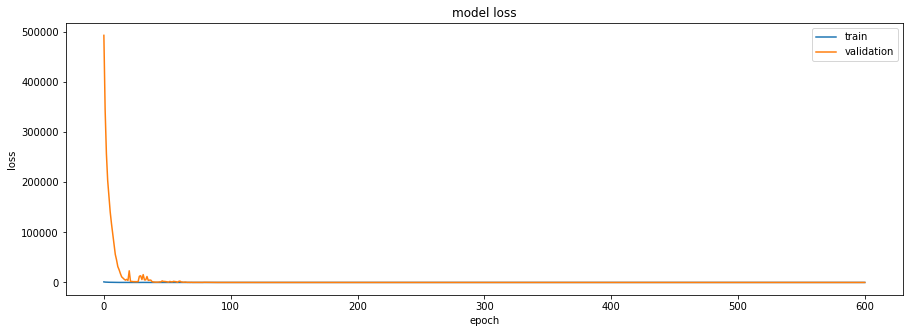

In [78]:
model.fit(train_data=X_train, train_label=Y_train, validation_data=(Valid_train, Valid_test), epochs=600, batch_size=12)

In [79]:
model.evaluate(X_test, Y_test)

Testing loss:  0.03869


In [80]:
predictions = model.predict(X_test)

In [81]:
predictions = np.abs(np.round(predictions))

In [82]:
years = X_test['year'].unique()

This function detects the bit shift to find the predicted day.

In [83]:
def get_predicted_days(X_test, predictions):
    start_index = 0
    predicted_days = list()

    for year in years:
        sliced_data = X_test[X_test['year'] == year]
        sliced_data.reset_index(inplace = True, drop = True)
        end_index = start_index + len(sliced_data)

        start_value = 0.0
        day = 0
        pred = predictions[start_index: end_index + 1]

        for i in range(len(sliced_data)):
            if pred[i] == start_value:
                day += 1
            elif pred[i] != start_value:
                predicted_days.append(day)
                start_index = end_index
                break

    return predicted_days
            

model1_predictions = get_predicted_days(X_test, predictions)
print(model1_predictions)

[80, 85, 92, 90, 85]


In [84]:
test_days = [79, 89, 93, 90, 82]
test_years =[1966, 1971, 1985, 1994, 2008]
print('R2 Score', r2_score(test_days, model1_predictions))

R2 Score 0.8032069970845481


### Model 2

In [85]:
model_2 = Sequential_Model()

model_2.Add_Dense_layer(input_shape=16 , output_shape=12, activation_function='sigmoid', dropout_rate=0.3)
## dropout rate is 0.3. It means that 30% of the neurons will be dropped randomly to prevent overfitting. 

model_2.Add_Dense_layer(input_shape=12, output_shape=8, activation_function='sigmoid', dropout_rate=0.3)
#model.Add_L2_Regularize()

model_2.Add_Dense_layer(input_shape=8, output_shape=1, activation_function='sigmoid', dropout_rate=0.1)

model_2.compile(loss='rmse', learning_rate=0.001)

Epoch - 0 ||| Training loss:  0.00400 ||| Validation loss:  0.33492
Epoch - 20 ||| Training loss:  0.00000 ||| Validation loss:  0.02502
Epoch - 40 ||| Training loss:  0.00003 ||| Validation loss:  0.03591
Epoch - 60 ||| Training loss:  0.00000 ||| Validation loss:  0.02937
Epoch - 80 ||| Training loss:  0.00022 ||| Validation loss:  0.02077
Epoch - 100 ||| Training loss:  0.00005 ||| Validation loss:  0.02117
Epoch - 120 ||| Training loss:  0.00001 ||| Validation loss:  0.01961
Epoch - 140 ||| Training loss:  0.00021 ||| Validation loss:  0.02239
Epoch - 160 ||| Training loss:  0.00023 ||| Validation loss:  0.02987
Epoch - 180 ||| Training loss:  0.00000 ||| Validation loss:  0.02848
Epoch - 200 ||| Training loss:  0.00006 ||| Validation loss:  0.02355
Epoch - 220 ||| Training loss:  0.00018 ||| Validation loss:  0.01681
Epoch - 240 ||| Training loss:  0.00005 ||| Validation loss:  0.01724
Epoch - 260 ||| Training loss:  0.00013 ||| Validation loss:  0.01829
Epoch - 280 ||| Training l

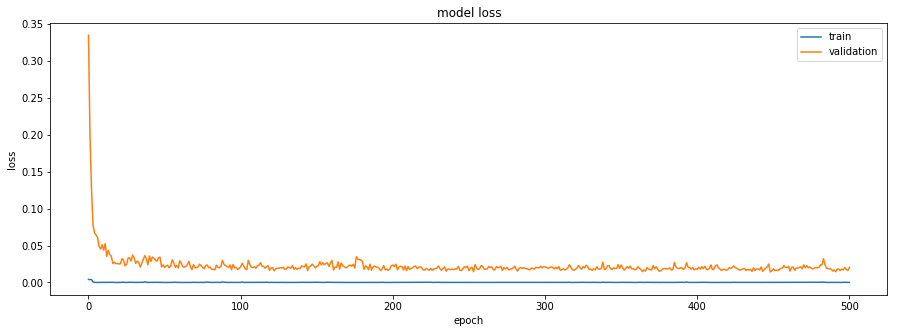

In [86]:
model_2.fit(train_data=X_train, train_label=Y_train, validation_data=(Valid_train, Valid_test), epochs=500, batch_size=12)

In [87]:
model_2.evaluate(X_test, Y_test)

Testing loss:  0.01357


In [88]:
predictions = model_2.predict(X_test)
predictions = np.abs(np.round(predictions))

In [89]:
model2_predictions = get_predicted_days(X_test, predictions)
print(model2_predictions)

[80, 86, 88, 84, 80]


In [90]:
print('R2 Score', r2_score(test_days, model2_predictions))

R2 Score 0.45335276967930027


In [91]:
prediction600 = sakura.get_prediction()
prediction600 = prediction600[600]
#print(prediction600)
prediction_600 = list()
for pred in prediction600:
    date = datetime(int(pred[0]), int(pred[1]), int(pred[2]))
    prediction_600.append(int(date.timetuple().tm_yday))

print(prediction_600)

[79, 86, 88, 87, 83]


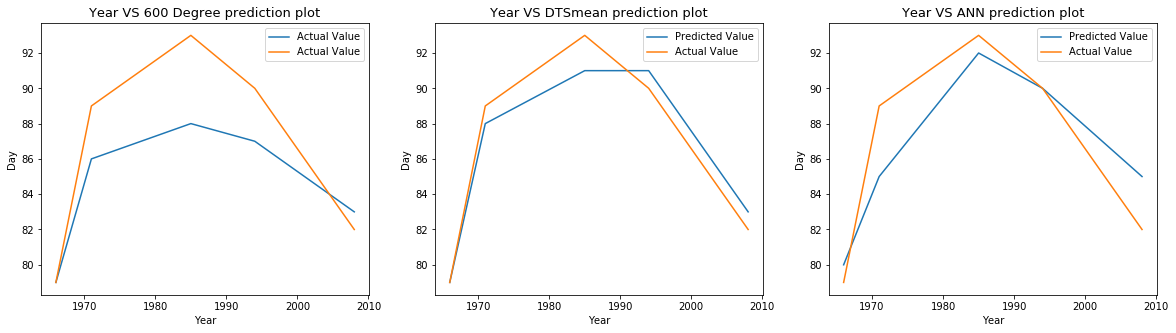

In [92]:
plt.figure(figsize = (20,5))
plt.subplot(131)
plt.plot(test_years,prediction_600,label="Actual Value")
plt.plot(test_years,test_days,label="Actual Value")
plt.title('Year VS 600 Degree prediction plot', fontsize= 13)
plt.xlabel('Year')
plt.ylabel('Day')
plt.legend()


plt.subplot(132)
plt.plot(test_years,sakura_regression.get_predictions(),label="Predicted Value")
plt.plot(test_years,test_days,label="Actual Value")
plt.title('Year VS DTSmean prediction plot', fontsize= 13)
plt.xlabel('Year')
plt.ylabel('Day')
plt.legend()

plt.subplot(133)
plt.plot(test_years,model1_predictions,label="Predicted Value")
plt.plot(test_years,test_days,label="Actual Value")
plt.title('Year VS ANN prediction plot', fontsize= 13)
plt.xlabel('Year')
plt.ylabel('Day')
plt.legend()

plt.show()

***
## 4. Trends of the Sakura blooming phenomenon (20pts total)

### Problem 4-1: (20pts)
Based on the data from the past 60 years, investigate and discuss trends in the sakura hibernation ($D_{j}$) and blooming ($BD_{j}$) phenomena in Tokyo.

***

In [93]:
total = len(preprocessed_weather_data)

In [94]:
years = preprocessed_weather_data['year'].unique()

In [95]:
temperature = list()
all_year = list()
avg_temp = list()
for year in years:
    data = preprocessed_weather_data[preprocessed_weather_data['year'] == year]
    temperature.append(np.mean(data['highest_temp']))
    avg_temp.append(np.mean(data['avg_temp']))
    all_year.append(year)

### Trends in highest temperature change

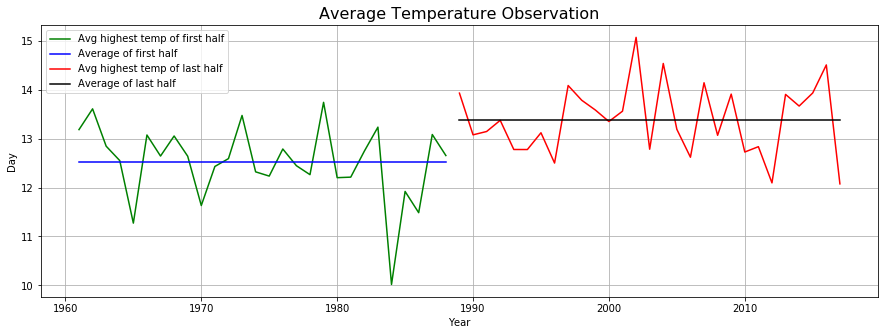

In [99]:
blank1 = list()
blank1.append(np.mean(temperature[0: len(all_year)//2]))

blank2 = list()
blank2.append(np.mean(temperature[len(all_year)//2: ]))

blank1 = blank1 * len(temperature[0: len(all_year)//2])
blank2 = blank2 * len(temperature[len(all_year)//2: ])

plt.figure(figsize=(15,5))
plt.plot(all_year[0: len(all_year)//2], temperature[0: len(all_year)//2], color='green',label="Avg highest temp of first half")
plt.plot(all_year[0: len(all_year)//2], blank1, color='blue', label='Average of first half')
plt.plot(all_year[len(all_year)//2:], temperature[len(all_year)//2:],color='red',label="Avg highest temp of last half")
plt.plot(all_year[len(all_year)//2:], blank2, color='black', label='Average of last half')
plt.grid(True)
plt.title('Average Highest Temperature Observation', fontsize= 16)
plt.xlabel('Year')
plt.ylabel('Day')
plt.legend()
plt.show()

### Observation
    - Temperature has risen in the later half.

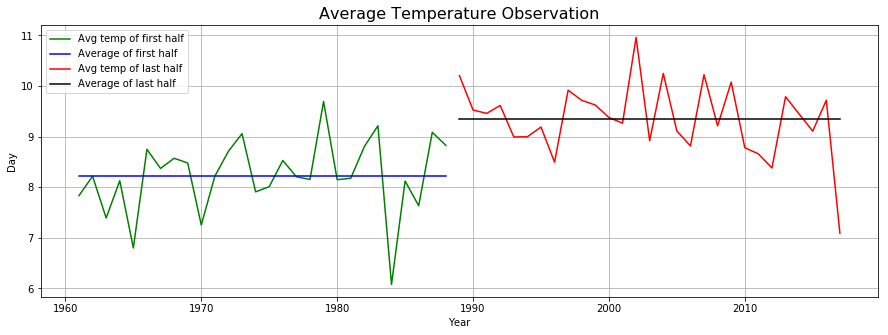

In [100]:
blank1 = list()
blank1.append(np.mean(avg_temp[0: len(all_year)//2]))

blank2 = list()
blank2.append(np.mean(avg_temp[len(all_year)//2: ]))

blank1 = blank1 * len(avg_temp[0: len(all_year)//2])
blank2 = blank2 * len(avg_temp[len(all_year)//2: ])

plt.figure(figsize=(15,5))
plt.plot(all_year[0: len(all_year)//2], avg_temp[0: len(all_year)//2], color='green',label="Avg temp of first half")
plt.plot(all_year[0: len(all_year)//2], blank1, color='blue', label='Average of first half')
plt.plot(all_year[len(all_year)//2:], avg_temp[len(all_year)//2:],color='red',label="Avg temp of last half")
plt.plot(all_year[len(all_year)//2:], blank2, color='black', label='Average of last half')
plt.grid(True)
plt.title('Average Temperature Observation', fontsize= 16)
plt.xlabel('Year')
plt.ylabel('Day')
plt.legend()
plt.show()

### Observation
    - Average Temperature has risen in the later half.

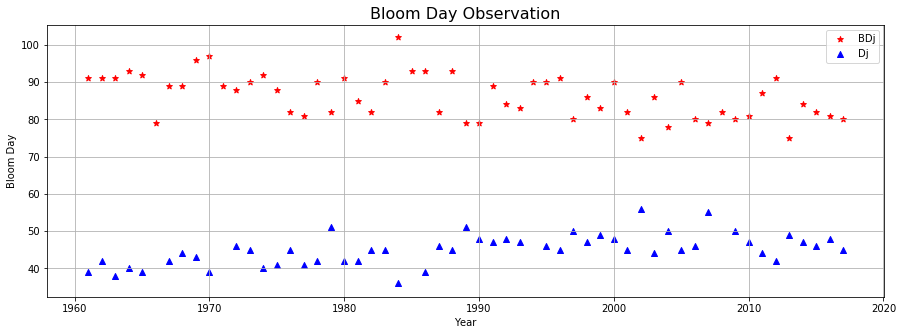

In [194]:
plt.figure(figsize=(15,5))
plt.scatter(plot_bloom_data['year'], plot_bloom_data['day'] , label = 'BDj', color='red', marker = '*')
plt.scatter(sakura_regression.get_dj()[0], sakura_regression.get_dj()[1] , label = 'Dj', color='blue', marker = '^')
plt.grid(True)
plt.title('Bloom Day Observation', fontsize= 16)
plt.xlabel('Year')
plt.ylabel('Bloom Day')
plt.legend()
plt.show()

### Observation
    - Bloom Date is coming closer than before.
    - Dj is increasing.